# Логистична регресия
Логистичната регресия е алгоритъм за машинно самообучение, който предвижда вероятността за случване на дадено събитие, като моделира данните посредством логистична или още наричана сигмоидна функция. Въпреки името си регресия това всъщност е класификационен алгоритъм. Използването на това име е поради исторически причини. Използваните променливи в алгоритъма могат да бъдат както дискретни така и непрекъснати. 

Примерни класификационни задачи които могат да бъдат решени чрез използване на логистична регресия:

* Спам филтри -- спам или не
* Медицински снимки -- рак или не
* Качество на поточна линия -- дефектна част или не 

Обикновенно за целевата променлива, по конвенция негативните примери се означават с 0, а положителните с 1. 
$$y \in {0, 1}$$
Тоест наличие на даден признак (спам) 1 и неналичние на признака (не-спам) 0.

Ще започнем с разглеждането на бинарен класификационнен проблем, като по-късно ще видим как задачата може да бъде разширена, така че да можем да разделяме обекти в множество класове.

## Визуализация на данните

Нека да обясним логистичната регресия с пример. Да предположим, че сте декан на ФМИ и искате да предвидите шансовете на кандидат студентите за прием на база тяхната оценка от два изпита. Имате историческите данни от предишни години и може да ги използвате като множество за обучени на логистичната регресия. За всеки обучаващ пример имате двете оценки на кандидата и решението на приемната комисия. Ще използваме логистична регресия, за да построим модел, които предвижда вероятността за прием в университета.

Нека да започнем като първо разгледаме данните с които разполагаме.

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

import os  
path = os.getcwd() + '/addmission.txt'  

#load the dataset
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])  
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


В данните имаме две непрекъснати независими променливи - "Exam1" и "Exam2". Променливата, която искаме да предвидим е "Admitted". Тази променлива е бинарна - приема две стоийности 0 или 1. Стройност 1 означава че кандидатът е приет, а 0 че не е приет за студент.
Нека да видим как изглеждат даните визуално, като ги начертаем на графика. Използваме червенa точка за да означим за кои стойности на двата изпита стойността на етикта "Admitted" е 0, а с зелено плюсче означаваме стойност 1 за "Admitted". 

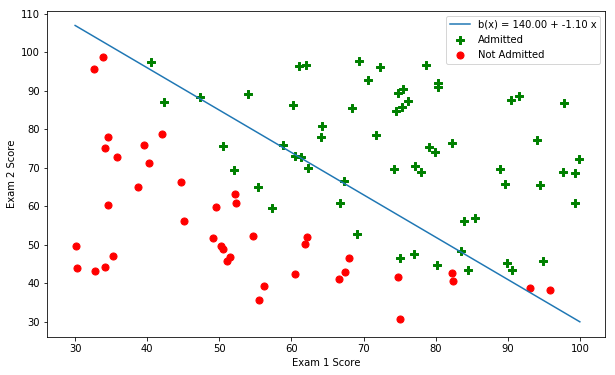

In [2]:
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(10,6))  
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='g', marker='P', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='o', label='Not Admitted')  
 
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

xb = np.linspace(30,100,100)
a = [140,-1.1]
ax.plot(xb, a[0] + a[1]*xb,  label='b(x) = %.2f + %.2f x' %(a[0], a[1]))
ax.legend() 
plt.show()

От тази графика виждаме, че данните са почти линейно сеперабелни, но имаме лека извивка, така че не можем да класифицираме коректно всички данни с права линия, но все пак може доста добре да извършим класификацията. Линията която разделя положителните от отрицателните примери, наричаме граница на раделянето. Границата на раздялянето може да бъде, също крива, повърхнина или хиперповърхнина.

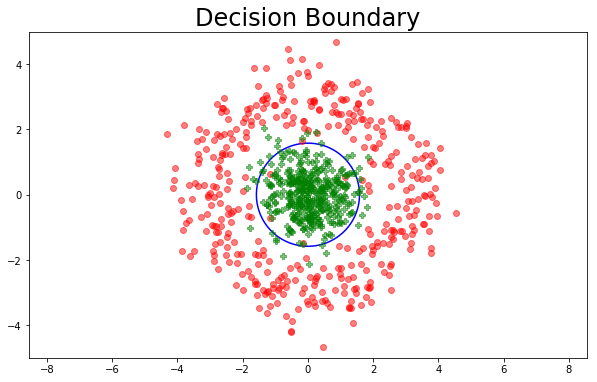

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
x3, y3 = np.random.multivariate_normal([0,0], [[.5,0],[0,.5]] , 400).T
t = np.linspace(0,2*np.pi,400)
ax.plot((3+x3)*np.sin(t), (3+y3)*np.cos(t), "ro", alpha=0.5)
ax.plot(x3, y3, "gP", alpha=0.5)

xb1 = np.linspace(-5.0, 5.0, 100)
xb2 = np.linspace(-5.0, 5.0, 100)
Xb1, Xb2 = np.meshgrid(xb1,xb2)
b = Xb1**2 + Xb2**2 - 2.5
ax.contour(Xb1,Xb2,b,[0], colors='b')
plt.title("Decision Boundary", fontsize=24)
ax.axis('equal')
plt.show()

Нека да имплементираме логистична регресия, за да обучим модел, които да намира оптималната линия за разделяне на примерите на два класа. 

## Представяне на хипотезата

В случеят на класификация няма смисъл $h_\theta (x)$ да заема стойности по-големи от 1 и по-малки от 0. За да променим хипотезата, така че да задоволява условието $0 \leq h_\theta (x) \leq 1$ използваме така наречената логистична или сигмоидна функция.

Хипотезата за логистичната регресия се дефинира като $h_\theta (x) = g ( \theta^T x )$ където $g$ е сигмоидната функция дефинирана по следният начин:
$$g(z) = \dfrac{1}{1 + e^{-z}}$$

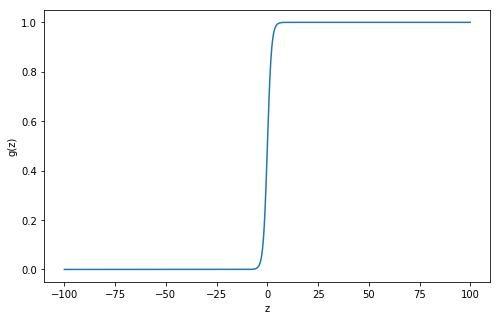

In [4]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

z = np.arange(-100, 100, step=0.1)
plt.subplots(figsize=(8,5))
plt.plot(z, sigmoid(z))
plt.xlabel("z")
plt.ylabel("g(z)")
plt.show()

Функцията g(z), показана по-горе, изобразява реалните числа в интервал (0, 1), което прави функцията подходяща за извършване на бинарна (да/не) класификация. 

Следващата ни стъпка е да имплементираме ценовата функция.

## Ценова функция

Ценовата функция оценява представянето на модела върху даденото моножество от обучаващи примери, за зададени конкретни параметри на модела.
Основната и задача е да наказва "лошите" параметри за модела, за да бъдат оптимизирани и да награждава "добрите" параметри. 
За логистична регресия не можем да използваме директно същата функция, която ползваме за линейна регресия, защото логистичната функция ще създаде множество локални минимуми, което не е добре за намирането на оптимален набор от параметри.

Ценовата функция за логистичната регресия има следният вид:
$$J(\theta) = \dfrac{1}{m} \sum_{i=1}^m \mathrm{Cost}(h_\theta(x^{(i)}),y^{(i)})$$
където $$\mathrm{Cost}(h_\theta(x),y) = -\log(h_\theta(x)) \textrm{ if y = 1} $$
 $$\mathrm{Cost}(h_\theta(x),y) = -\log(1-h_\theta(x)) \textrm{ if y = 0} $$ 
 

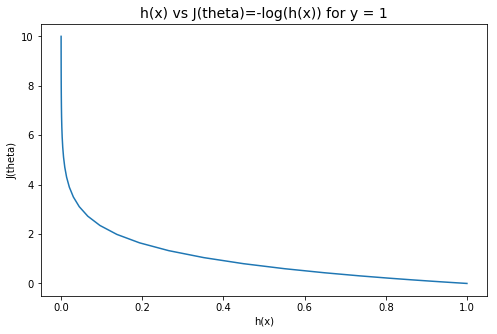

In [5]:
# За да разберем как работи ценовата функция 
# нека да разгледаме следната графика 
x = np.linspace(-10,10,50)
plt.subplots(figsize=(8,5))
plt.plot(sigmoid(x), -np.log(sigmoid(x)))
plt.title("h(x) vs J(theta)=-log(h(x)) for y = 1", fontsize=14)
plt.xlabel('h(x)')
plt.ylabel('J(theta)')
plt.show()

Както се вижда от графиката когато $y = 1$, ценовата функция дава големи стойности, когато $h(\theta)$ отива към $0$. Тоест фаворизира $h(\theta)$ когато хипотезата отива към $1$, което е това което искаме.

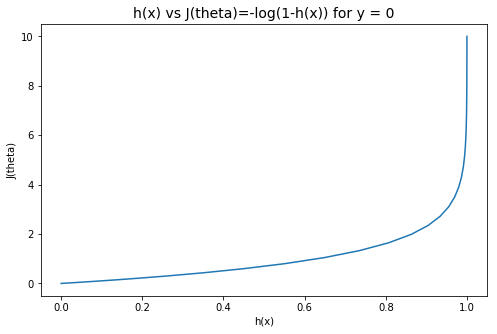

In [6]:
x = np.linspace(-10,10,50)
plt.subplots(figsize=(8,5))
plt.plot(sigmoid(x), -np.log(1-sigmoid(x)))
plt.title("h(x) vs J(theta)=-log(1-h(x)) for y = 0", fontsize=14)
plt.xlabel('h(x)')
plt.ylabel('J(theta)')
plt.show()

Когато y = 0 ценовата функция наказва $h(x)$ когато функцията отива към 1. 

Ценовата функция можем да запишем комбинирано по следният начин:
$$J(\theta) = -\frac{1}{m}\sum^{m}_{i=1} y^{(i)} log(h_a(x^{(i)})) + (1-y^{(i)})log(1 - h_a(x^{(i)}))$$

In [7]:
def cost(theta, X, y):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

След като имаме функция даваща едно число, което е сума на грешките (разликите) между вероятността  за принадлеждност към даден клас назначена на модела и истинските етикети на примерите, можем да пристъпим към реализиране на процедурата по градиентно спускане. 
За целта трябва да направим няколко подготвителни стъпки.

In [8]:
# добавяме една колона с единици в началото -за да можем да векторизираме имплементацията

data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]  
X = data.iloc[:,0:cols-1]  
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)  
y = np.array(y.values)  
theta = np.zeros(3)  

In [9]:
# Когато умножаваме матрици е хубаво да проверяваме размерността им. 
X.shape, theta.shape, y.shape  

((100, 3), (3,), (100, 1))

In [10]:
# Нека да изчислим цената за началните параметри.
cost(theta, X, y) 

0.69314718055994529

Сега след като имаме работеща ценова функция следващата стъпка е да имплементираме функция която изчислява градиента за пареметрите на модела, за да можем да променим параметрите, така че да се подобри и поведението на модела върху обучаващите данни. Градиентното спускане обновява пареметрите на модела, по начин който гарантира намаляване на грешката (цената) на всяка стъпка.

In [11]:
def gradient(theta, X, y):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)

    return grad

Тази функция имплементира една стъпка от градиентното спускане. За да оптимизираме параметрите за зададената функция използваме функцията fmin_tnc от пакета SciPy.

In [12]:
import scipy.optimize as opt  
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))  
cost(result[0], X, y)  

0.20349770158947458

Сега имаме оптималните параметри за даденото множество. Остава да съдадем една функция, която да прави предсказания за подедено ново множество от данни X, като използвам научените параметри тита. След това можем да използваме тази функция за да оценим точността на нашият класификатор.

In [13]:
def predict(theta, X):  
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

theta_min = np.matrix(result[0])  
predictions = predict(theta_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print 'accuracy = {0}%'.format(accuracy)  

accuracy = 89%


Този класификатор базиран на логистична регресия дава точност от 89%. Това е точността изчислена върху обучаващото множество. На практика за използване на точността се използва тестово множество с различни данни от тези на обучаващото.

## Регуларизирана логистична регресия

След като имаме работеща имплементация на логистична регресия, ще се опитаме да подобрим модела като добавим релуларизация. Регуларизацията представлява допълнителен член добавен към ценовата функция, които кара алгоритъмът да предпочита "прости" модели (в този случай, модели с по малки коефиценти). На теорията регуларизацията позволява да се минимизира преспецификация и по този начин се подобрява точността на модела. Ще проложим регуларизирана логистична регресия върху различни данни от предходната задача.

$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m \large[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\large] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

### Домашно
Да предложим, че отговарята за тестването на продукцията на завод за мокрочипове. Имате множество от тестовите резултати от два различни теста. От тези тестове трябва да решите дали чиповете да бъдат приети като годни или да бъдат бракувани. За да вземете решение трябв да построите модел използващ регуларизирана логистична регресия. По долу е показана графика на данните, които имате.

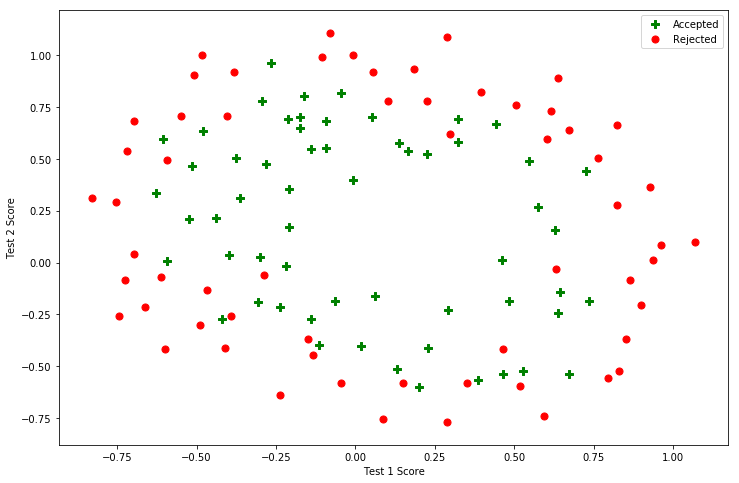

In [14]:
path = os.getcwd() + '/microchips.txt'  
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])

positive = data2[data2['Accepted'].isin([1])]  
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='g', marker='P', label='Accepted')  
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='o', label='Rejected')  
ax.legend()  
ax.set_xlabel('Test 1 Score')  
ax.set_ylabel('Test 2 Score')
plt.show()